<a href="https://colab.research.google.com/github/amit-kumar56/Text-Summarisation/blob/main/news_summary_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving news_summary.csv to news_summary (1).csv


In [ ]:
import zipfile
import io
zf = zipfile.ZipFile('data.zip', 'r')
zf.extractall() 

In [ ]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from nltk import download
download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
#from attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
reviews_org = pd.read_csv("news_summary.csv", encoding='latin-1')

In [ ]:
reviews_org.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in offices order,http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.html?utm_source=inshorts&utm_medium...,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorcing rich man',http://www.hindustantimes.com/bollywood/malaika-arora-khan-was-trolled-for-divorcing-a-rich-man-her-reply-is-dignity-itself/story-oIPZNI9deImCmabLMMwR2H.html?utm_source=inshorts&utm_medium=referra...,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...","From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster ..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS' form,http://www.hindustantimes.com/patna/bihar-igims-form-loses-virginity-after-row-opts-for-unmarried-instead/story-8XmHIg39otGBoZAYEBQxMK.html?utm_source=inshorts&utm_medium=referral&utm_campaign=ful...,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...","The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna amended its marital declaration form on Thursday, replacing the word ?virgin? with ?unmarried? after controversy.Until now, new rec..."
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before being killed,http://indiatoday.intoday.in/story/abu-dujana-last-phone-call-lashkar-e-taiba-jammu-and-kashmir/1/1017550.html?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a...","Lashkar-e-Taiba's Kashmir commander Abu Dujana was killed in an encounter in a village in Pulwama district of Jammu and Kashmir earlier this week. Dujana, who had managed to give the security forc..."
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of sex trafficking,http://indiatoday.intoday.in/story/sex-trafficking-mumbai-rescue-me-maharashtra-international-labour-organization-forced-labour-trafficking-traning-hotel-staff/1/1017210.html?utm_source=inshorts&u...,"Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors for days. A mobile ph...","Hotels in Mumbai and other Indian cities are to train their staff to spot signs of sex trafficking such as frequent requests for bed linen changes or a ""Do not disturb"" sign left on the door for d..."


In [ ]:
reviews_org.isnull().sum()

author         0
date           0
headlines      0
read_more      0
text           0
ctext        118
dtype: int64

In [ ]:
CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR"}

In [ ]:
CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

In [ ]:
EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE)

In [ ]:
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}

In [ ]:
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = EMAIL_REGEX.sub(' ',text)
    text = CURRENCY_REGEX.sub(' ',text)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"'s\b","", text)
    text = re.sub(r'&amp;', '', text) 
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [ ]:
cleaned_headlines = []
cleaned_text = []

for headlines in reviews_org['headlines']:
    cleaned_headlines.append(clean_text(headlines, remove_stopwords=False))
print("Headlines are complete.")

for text in reviews_org['text']:
    cleaned_text.append(clean_text(text))
print("Texts are complete.")

Headlines are complete.
Texts are complete.


In [ ]:
for i in range(4):
    print("Review: ",i+1) # You can change it by "Review" to "Headline"
    print(cleaned_headlines[i])
    print('-'*80)
    print(cleaned_text[i])
    print()

Review:  1
daman   diu revokes mandatory rakshabandhan in offices order
--------------------------------------------------------------------------------
administration union territory daman diu revoked order made compulsory women tie rakhis male colleagues occasion rakshabandhan august 7 administration forced withdraw decision within 24 hours issuing circular received flak employees slammed social media

Review:  2
malaika slams user who trolled her for 'divorcing rich man'
--------------------------------------------------------------------------------
malaika arora slammed instagram user trolled divorcing rich man fun alimony life wearing short clothes going gym salon enjoying vacation user commented malaika responded certainly got get damn facts right spewing sh know nothing

Review:  3
'virgin' now corrected to 'unmarried' in igims' form
--------------------------------------------------------------------------------
indira gandhi institute medical sciences igims patna thursday mad

In [ ]:
from pickle import dump, load
dump(reviews_org, open('reviews_org.pkl', 'wb'))

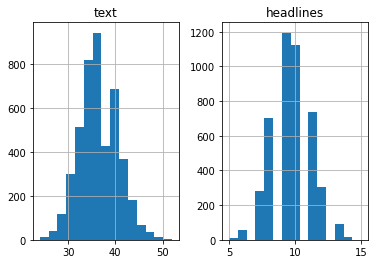

In [ ]:
import matplotlib.pyplot as plt #pip install matplotlib

text_word_count = []
headlines_word_count = []

for i in cleaned_text:
    text_word_count.append(len(i.split()))
for i in cleaned_headlines:
    headlines_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text': text_word_count, 'headlines': headlines_word_count})
length_df.hist(bins=15)
plt.show()

In [ ]:
count = 0
for i in cleaned_text:
    if(len(i.split())<=55):
        count += 1
print(count/len(cleaned_text))

1.0


In [ ]:
max_headlines_len=15
max_text_len=55

cleaned_text = np.array(cleaned_text)
cleaned_headlines = np.array(cleaned_headlines)

short_text=[]
short_headlines=[]

for i in range(len(cleaned_text)):
    
    if(len(cleaned_headlines[i].split())<=max_headlines_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_headlines.append(cleaned_headlines[i])

df=pd.DataFrame({'text':short_text,'headlines':short_headlines})
df['headlines'] = df['headlines'].apply(lambda x : 'sostok '+ x + ' eostok')

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['headlines']),test_size=0.1,random_state=0,shuffle=True)
df.head()

,text,headlines
0,administration union territory daman diu revoked order made compulsory women tie rakhis male colleagues occasion rakshabandhan august 7 administration forced withdraw decision within 24 hours issu...,sostok daman diu revokes mandatory rakshabandhan in offices order eostok
1,malaika arora slammed instagram user trolled divorcing rich man fun alimony life wearing short clothes going gym salon enjoying vacation user commented malaika responded certainly got get damn fac...,sostok malaika slams user who trolled her for 'divorcing rich man' eostok
2,indira gandhi institute medical sciences igims patna thursday made corrections marital declaration form changing 'virgin' option 'unmarried' earlier bihar health minister defined virgin unmarried ...,sostok 'virgin' now corrected to 'unmarried' in igims' form eostok
3,lashkar e taiba kashmir commander abu dujana killed security forces said kabhi hum aage kabhi aap aaj aapne pakad liya mubarak ho aapko today caught congratulations caught added surrender whatever...,sostok aaj aapne pakad liya let man dujana before being killed eostok
4,hotels maharashtra train staff spot signs sex trafficking including frequent requests bed linen changes 'do disturb' signs left room doors days mobile phone app called rescue allow staff alert pol...,sostok hotel staff to get training to spot signs of sex trafficking eostok


In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print(x_voc)

% of rare words in vocabulary: 68.12220256063287
Total Coverage of rare words: 13.023654231389239
6126


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_headlines_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_headlines_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)

% of rare words in vocabulary: 85.91779542269967
Total Coverage of rare words: 26.708114207848066


(4062, 4062)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
print(x_tr)

[[   7  532 1204 ...    0    0    0]
 [  72  179    9 ...    0    0    0]
 [  56  416  624 ...    0    0    0]
 ...
 [  40 5935 5936 ...    0    0    0]
 [  53  967  199 ...    0    0    0]
 [  97   52 4470 ...    0    0    0]]


In [ ]:
pip install keras-attention

In [ ]:
import tensorflow as tf


In [ ]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-cp36-none-any.whl size=17290 sha256=5ea3d78f343d89c32a51d3698b3fd6f9eb66b1fe82dfc8a15908376d4607286b
  Stored in directory: /root/.cache/pip/wheels/70/87/01/76c703d5401b65e323927c1fdc665f3fb143282ff67d71e859
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention

In [ ]:
from keras import backend as K 
from tensorflow.keras.layers import dot, Activation
# from tensorflow.keras.layers import AttentionLayer

K.clear_session()
#from attention import AttentionLayer
latent_dim = 200
embedding_dim=110

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
attention = Activation('softmax')(attention)
attn_out = dot([attention, encoder_outputs], axes=[2,1])
# attn_layer = AttentionLayer(name='attention_layer')
# attn_layer = SeqSelfAttention(attention_activation='sigmoid')
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 55, 110)      673860      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 55, 200), (N 248800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
print(x_tr)

[[   7  532 1204 ...    0    0    0]
 [  72  179    9 ...    0    0    0]
 [  56  416  624 ...    0    0    0]
 ...
 [  40 5935 5936 ...    0    0    0]
 [  53  967  199 ...    0    0    0]
 [  97   52 4470 ...    0    0    0]]


In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=30,batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/30
32/32 [==============================] - 266s 8s/step - loss: 2.4978 - accuracy: 0.5791 - val_loss: 2.6327 - val_accuracy: 0.5872
Epoch 2/30
32/32 [==============================] - 250s 8s/step - loss: 2.4408 - accuracy: 0.5825 - val_loss: 2.6332 - val_accuracy: 0.5847
Epoch 3/30
32/32 [==============================] - 253s 8s/step - loss: 2.3931 - accuracy: 0.5882 - val_loss: 2.6347 - val_accuracy: 0.5904
Epoch 4/30
32/32 [==============================] - 246s 8s/step - loss: 2.3729 - accuracy: 0.5878 - val_loss: 2.6387 - val_accuracy: 0.5896
Epoch 5/30
32/32 [==============================] - 249s 8s/step - loss: 2.3655 - accuracy: 0.5872 - val_loss: 2.6402 - val_accuracy: 0.5877
Epoch 6/30
32/32 [==============================] - 248s 8s/step - loss: 2.3346 - accuracy: 0.5917 - val_loss: 2.6290 - val_accuracy: 0.5875
Epoch 7/30
32/32 [==============================] - 245s 8s/step - loss: 2.3054 - accuracy: 0.5920 - val_loss: 2.6301 - val_accuracy: 0.5875
Epoch 8/30
32

In [ ]:
acc=history.history['accuracy']

In [ ]:
print(x_tr)

[[   1   37    7 ...    0    0    0]
 [4576   55   36 ...    0    0    0]
 [   8 2185    1 ...    0    0    0]
 ...
 [  97 4088 4089 ...    0    0    0]
 [  53  100 1015 ...    0    0    0]
 [ 163    6  108 ...    0    0    0]]


In [ ]:
max(acc)*100

64.11861777305603

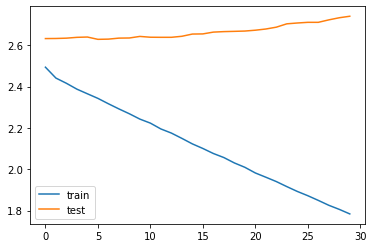

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

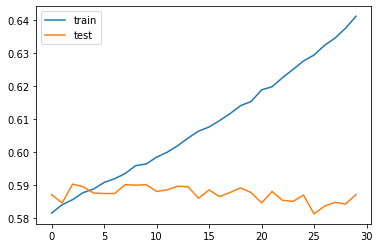

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index
                                                                                                                                                                                                                                        
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))
dec_emb2= dec_emb_layer(decoder_inputs) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

"""
DEBUG: Check if Attention Layer works properly
attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
attention = Activation('softmax')(attention)
attn_out = dot([attention, encoder_outputs], axes=[2,1])
"""
attention = dot([decoder_outputs2, decoder_hidden_state_input], axes=[2, 2])
attention = Activation('softmax')(attention)
attn_out_inf = dot([attention, decoder_hidden_state_input], axes=[2,1])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['sostok']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c
    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


TypeError: ignored

In [ ]:
text='''Santiago is a Shepherd who has a recurring dream which is supposedly prophetic. Inspired on learning this, he undertakes a journey to Egypt to discover the meaning of life and fulfill his destiny. During the course of his travels, he learns of his true purpose and meets many characters, including an “Alchemist”, that teach him valuable lessons about achieving his dreams. Santiago sets his sights on obtaining a certain kind of “treasure” for which he travels to Egypt. The key message is, “when you want something, all the universe conspires in helping you to achieve it.” Towards the final arc, Santiago gets robbed by bandits who end up revealing that the “treasure” he was looking for is buried in the place where his journey began. The end.'''

In [ ]:
for i in range(0,7):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: the police has banned in groups in leone citing public order and safety the police accused people in groups of insults traffic on vehicles playing music and property from other members of the public it said violators will be with according to law you have been warned 
Original summary: start bans in groups end 
Predicted summary:  start delhi airport to end


Review: thirty two year old jammu and kashmir police officer ahmed dar who was buried on friday had written facebook post just yourself in your grave down there in that dark hole alone dar along with five other policemen was killed on friday in an in in anantnag district by suspected lashkar e taiba let militants 
Original summary: start just in cop on end 
Predicted summary:  start delhi metro to install end


Review: for changing the names of the central government schemes bjp leader chandra kumar bose compared west bengal cm mamata banerjee to mughal babur who demolished ram temple in ayodhya and built babri masjid thin

In [ ]:
!pip install git+https://github.com/tagucci/pythonrouge.git



  Cloning https://github.com/tagucci/pythonrouge.git to /tmp/pip-req-build-t5mtopaz
  Running command git clone -q https://github.com/tagucci/pythonrouge.git /tmp/pip-req-build-t5mtopaz
  Created wheel for pythonrouge: filename=pythonrouge-0.2-cp36-none-any.whl size=285402 sha256=4894cc2d5b63ae49ca4a2b4751976607f91fc3dbf513a846bef2241f1d925daf
  Stored in directory: /tmp/pip-ephem-wheel-cache-nbdhn6hi/wheels/fd/ff/be/6716935d513fa8656ab185cb0aa70aed382b72dda42bf09c95
Successfully built pythonrouge


In [ ]:
!apt-get install -y cpanminus

!cpanm --force XML::Parser

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libalgorithm-c3-perl libb-hooks-endofscope-perl libb-hooks-op-check-perl
  libclass-c3-perl libclass-c3-xs-perl libclass-method-modifiers-perl
  libclass-xsaccessor-perl libcpan-changes-perl libcpan-distnameinfo-perl
  libcpan-meta-check-perl libdata-optlist-perl libdata-perl-perl
  libdata-section-perl libdevel-callchecker-perl
  libdevel-globaldestruction-perl libdynaloader-functions-perl
  libencode-locale-perl libexporter-tiny-perl libfile-pushd-perl
  libfile-slurp-perl libgetopt-long-descriptive-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl
  libimport-into-perl libio-html-perl libio-stringy-perl
  liblist-moreutils-perl liblocal-lib-perl liblwp-mediatypes-perl
  libmodule-build-perl libmodule-cpanfile-perl libmodule-implementation-perl
  libmodule-runtime-perl libmodule-signature-perl libmoo

In [ ]:
from pythonrouge.pythonrouge import Pythonrouge


# initialize setting of ROUGE to evaluate ROUGE-1, 2, W and SU4

 

rouge = Pythonrouge(summary_file_exist=False,

                    summary=[[x_tr[0]]], reference=[[[y_tr[0]]]],

                    n_gram=2, ROUGE_SU4=True, ROUGE_L=True,ROUGE_W=True,ROUGE_W_Weight=1.2,

                    recall_only=False, stemming=True, stopwords=True,

                    word_level=True, length_limit=True, length=50,

                    use_cf=False, cf=95, scoring_formula='average',

                    resampling=True, samples=1000, favor=True, p=0.5)

score = rouge.calc_score()

print(score)

{'ROUGE-1-R': 0.8, 'ROUGE-1-P': 0.26087, 'ROUGE-1-F': 0.39344, 'ROUGE-2-R': 0.71429, 'ROUGE-2-P': 0.22222, 'ROUGE-2-F': 0.33898, 'ROUGE-L-R': 0.8, 'ROUGE-L-P': 0.26087, 'ROUGE-L-F': 0.39344, 'ROUGE-W-1.2-R': 0.44658, 'ROUGE-W-1.2-P': 0.25029, 'ROUGE-W-1.2-F': 0.32079, 'ROUGE-SU4-R': 0.7027, 'ROUGE-SU4-P': 0.2, 'ROUGE-SU4-F': 0.31138}


In [ ]:
from pythonrouge.pythonrouge import Pythonrouge

# initialize setting of ROUGE to evaluate ROUGE-1, 2, W and SU4

 

rouge = Pythonrouge(summary_file_exist=False,

                    summary=[[seq2summary(y_tr[2])]], reference=[[[decode_sequence(x_tr[2].reshape(1,max_text_len))]]],

                    n_gram=2, ROUGE_SU4=True, ROUGE_L=True,ROUGE_W=True,ROUGE_W_Weight=1.2,

                    recall_only=False, stemming=True, stopwords=True,

                    word_level=True, length_limit=True, length=50,

                    use_cf=False, cf=95, scoring_formula='average',

                    resampling=True, samples=1000, favor=True, p=0.5)

score1 = rouge.calc_score()

print(score1)

{'ROUGE-1-R': 0.5, 'ROUGE-1-P': 0.2, 'ROUGE-1-F': 0.28571, 'ROUGE-2-R': 0.0, 'ROUGE-2-P': 0.0, 'ROUGE-2-F': 0.0, 'ROUGE-L-R': 0.5, 'ROUGE-L-P': 0.2, 'ROUGE-L-F': 0.28571, 'ROUGE-W-1.2-R': 0.43528, 'ROUGE-W-1.2-P': 0.2, 'ROUGE-W-1.2-F': 0.27407, 'ROUGE-SU4-R': 0.5, 'ROUGE-SU4-P': 0.07143, 'ROUGE-SU4-F': 0.125}


In [ ]:
from pythonrouge.pythonrouge import Pythonrouge


# initialize setting of ROUGE to evaluate ROUGE-1, 2, W and SU4

 

rouge = Pythonrouge(summary_file_exist=False,

                    summary=[[seq2summary(y_tr[1])]], reference=[[[decode_sequence(x_tr[1].reshape(1,max_text_len))]]],

                    n_gram=2, ROUGE_SU4=True, ROUGE_L=True,ROUGE_W=True,ROUGE_W_Weight=1.2,

                    recall_only=False, stemming=True, stopwords=True,

                    word_level=True, length_limit=True, length=50,

                    use_cf=False, cf=95, scoring_formula='average',

                    resampling=True, samples=1000, favor=True, p=0.5)

score1 = rouge.calc_score()

print(score1)

{'ROUGE-1-R': 0.2, 'ROUGE-1-P': 0.2, 'ROUGE-1-F': 0.2, 'ROUGE-2-R': 0.0, 'ROUGE-2-P': 0.0, 'ROUGE-2-F': 0.0, 'ROUGE-L-R': 0.2, 'ROUGE-L-P': 0.2, 'ROUGE-L-F': 0.2, 'ROUGE-W-1.2-R': 0.14496, 'ROUGE-W-1.2-P': 0.2, 'ROUGE-W-1.2-F': 0.16809, 'ROUGE-SU4-R': 0.07143, 'ROUGE-SU4-P': 0.07143, 'ROUGE-SU4-F': 0.07143}


In [ ]:
from pythonrouge.pythonrouge import Pythonrouge

# initialize setting of ROUGE to evaluate ROUGE-1, 2, W and SU4

rouge = Pythonrouge(summary_file_exist=False,

                    summary=[[seq2summary(y_tr[3])]], reference=[[[decode_sequence(x_tr[3].reshape(1,max_text_len))]]],

                    n_gram=2, ROUGE_SU4=True, ROUGE_L=True,ROUGE_W=True,ROUGE_W_Weight=1.2,

                    recall_only=False, stemming=True, stopwords=True,

                    word_level=True, length_limit=True, length=50,

                    use_cf=False, cf=95, scoring_formula='average',

                    resampling=True, samples=1000, favor=True, p=0.5)

score1 = rouge.calc_score()

print(score1)

{'ROUGE-1-R': 0.66667, 'ROUGE-1-P': 0.33333, 'ROUGE-1-F': 0.44444, 'ROUGE-2-R': 0.5, 'ROUGE-2-P': 0.2, 'ROUGE-2-F': 0.28571, 'ROUGE-L-R': 0.66667, 'ROUGE-L-P': 0.33333, 'ROUGE-L-F': 0.44444, 'ROUGE-W-1.2-R': 0.53516, 'ROUGE-W-1.2-P': 0.33333, 'ROUGE-W-1.2-F': 0.41079, 'ROUGE-SU4-R': 0.4, 'ROUGE-SU4-P': 0.1, 'ROUGE-SU4-F': 0.16}


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [(seq2summary(y_tr[0])).split()]
candidate = (decode_sequence(x_tr[0].reshape(1,max_text_len))).split()
#score_bleu = sentence_bleu(reference, candidate,weights=(0.25, 0.25, 0.25, 0.25))
#print(score)
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))
#print(reference)
#print(candidate)

Individual 1-gram: 0.200000
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [(seq2summary(y_tr[1])).split()]
candidate = (decode_sequence(x_tr[1].reshape(1,max_text_len))).split()
#score_bleu = sentence_bleu(reference, candidate,weights=(0.25, 0.25, 0.25, 0.25))
#print(score)
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))
#print(reference)
#print(candidate)

Individual 1-gram: 0.322062
Individual 2-gram: 0.125246
Individual 3-gram: 0.751477
Individual 4-gram: 0.751477


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [(seq2summary(y_tr[2])).split()]
candidate = (decode_sequence(x_tr[2].reshape(1,max_text_len))).split()
#score_bleu = sentence_bleu(reference, candidate,weights=(0.25, 0.25, 0.25, 0.25))
#print(score)
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))
#print(reference)
#print(candidate)

Individual 1-gram: 0.282161
Individual 2-gram: 0.846482
Individual 3-gram: 0.846482
Individual 4-gram: 0.846482


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [(seq2summary(y_tr[3])).split()]
candidate = (decode_sequence(x_tr[3].reshape(1,max_text_len))).split()
#score_bleu = sentence_bleu(reference, candidate,weights=(0.25, 0.25, 0.25, 0.25))
#print(score)
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))
#print(reference)
#print(candidate)

Individual 1-gram: 0.217299
Individual 2-gram: 0.086920
Individual 3-gram: 0.434598
Individual 4-gram: 0.434598


In [ ]:
###### BASED ON TEXT RANKING##################

In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from scipy import spatial
import networkx as nx

In [ ]:
text='''Santiago is a Shepherd who has a recurring dream which is supposedly prophetic. Inspired on learning this, he undertakes a journey to Egypt to discover the meaning of life and fulfill his destiny. During the course of his travels, he learns of his true purpose and meets many characters, including an “Alchemist”, that teach him valuable lessons about achieving his dreams. Santiago sets his sights on obtaining a certain kind of “treasure” for which he travels to Egypt. The key message is, “when you want something, all the universe conspires in helping you to achieve it.” Towards the final arc, Santiago gets robbed by bandits who end up revealing that the “treasure” he was looking for is buried in the place where his journey began. The end.'''

In [ ]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
sentences=sent_tokenize(text)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
sentences_clean=[re.sub(r'[^\w\s]','',sentence.lower()) for sentence in sentences]
stop_words = stopwords.words('english')
sentence_tokens=[[words for words in sentence.split(' ') if words not in stop_words] for sentence in sentences_clean]

In [ ]:
w2v=Word2Vec(sentence_tokens,size=1,min_count=1,iter=1000)

In [ ]:
sentence_embeddings=[[w2v[word][0] for word in words] for words in sentence_tokens]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
max_len=max([len(tokens) for tokens in sentence_tokens])

In [ ]:
sentence_embeddings=[np.pad(embedding,(0,max_len-len(embedding)),'constant') for embedding in sentence_embeddings]

In [ ]:
similarity_matrix = np.zeros([len(sentence_tokens), len(sentence_tokens)])
for i,row_embedding in enumerate(sentence_embeddings):
    for j,column_embedding in enumerate(sentence_embeddings):
        similarity_matrix[i][j]=1-spatial.distance.cosine(row_embedding,column_embedding)

In [ ]:
nx_graph = nx.from_numpy_array(similarity_matrix)
scores = nx.pagerank(nx_graph)

In [ ]:
top_sentence={sentence:scores[index] for index,sentence in enumerate(sentences)}
top=dict(sorted(top_sentence.items(), key=lambda x: x[1], reverse=True)[:4])

In [ ]:
g_sent=""
for sent in sentences:
    if sent in top.keys():
        g_sent=g_sent+sent
print(g_sent)   

Santiago is a Shepherd who has a recurring dream which is supposedly prophetic.Inspired on learning this, he undertakes a journey to Egypt to discover the meaning of life and fulfill his destiny.During the course of his travels, he learns of his true purpose and meets many characters, including an “Alchemist”, that teach him valuable lessons about achieving his dreams.Santiago sets his sights on obtaining a certain kind of “treasure” for which he travels to Egypt.


In [ ]:
!pip install git+https://github.com/tagucci/pythonrouge.git


  Cloning https://github.com/tagucci/pythonrouge.git to /tmp/pip-req-build-jutf5p65
  Running command git clone -q https://github.com/tagucci/pythonrouge.git /tmp/pip-req-build-jutf5p65
  Created wheel for pythonrouge: filename=pythonrouge-0.2-cp36-none-any.whl size=285402 sha256=5cfbfd71fa3d7efbbf320bb64636c14596b41b6b6adcf06e711fb3700fbf9e40
  Stored in directory: /tmp/pip-ephem-wheel-cache-y4rdqmf2/wheels/fd/ff/be/6716935d513fa8656ab185cb0aa70aed382b72dda42bf09c95
Successfully built pythonrouge


In [ ]:
!apt-get install -y cpanminus

!cpanm --force XML::Parser

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libalgorithm-c3-perl libb-hooks-endofscope-perl libb-hooks-op-check-perl
  libclass-c3-perl libclass-c3-xs-perl libclass-method-modifiers-perl
  libclass-xsaccessor-perl libcpan-changes-perl libcpan-distnameinfo-perl
  libcpan-meta-check-perl libdata-optlist-perl libdata-perl-perl
  libdata-section-perl libdevel-callchecker-perl
  libdevel-globaldestruction-perl libdynaloader-functions-perl
  libencode-locale-perl libexporter-tiny-perl libfile-pushd-perl
  libfile-slurp-perl libgetopt-long-descriptive-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl
  libimport-into-perl libio-html-perl libio-stringy-perl
  liblist-moreutils-perl liblocal-lib-perl liblwp-mediatypes-perl
  libmodule-build-perl libmodule-cpanfile-perl libmodule-implementation-perl
  libmodule-runtime-perl libmodule-signature-perl libmoo

In [ ]:
from pythonrouge.pythonrouge import Pythonrouge


# initialize setting of ROUGE to evaluate ROUGE-1, 2, W and SU4

 

rouge = Pythonrouge(summary_file_exist=False,

                    summary=[[text]], reference=[[[g_sent]]],

                    n_gram=2, ROUGE_SU4=True, ROUGE_L=True,ROUGE_W=True,ROUGE_W_Weight=1.2,

                    recall_only=False, stemming=True, stopwords=True,

                    word_level=True, length_limit=True, length=50,

                    use_cf=False, cf=95, scoring_formula='average',

                    resampling=True, samples=1000, favor=True, p=0.5)

score = rouge.calc_score()

print(score)

{'ROUGE-1-R': 0.95833, 'ROUGE-1-P': 1.0, 'ROUGE-1-F': 0.97872, 'ROUGE-2-R': 0.95652, 'ROUGE-2-P': 1.0, 'ROUGE-2-F': 0.97778, 'ROUGE-L-R': 0.95833, 'ROUGE-L-P': 1.0, 'ROUGE-L-F': 0.97872, 'ROUGE-W-1.2-R': 0.50754, 'ROUGE-W-1.2-P': 1.0, 'ROUGE-W-1.2-F': 0.67334, 'ROUGE-SU4-R': 0.95312, 'ROUGE-SU4-P': 1.0, 'ROUGE-SU4-F': 0.976}


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [text.split()]
candidate = g_sent.split()
#score_bleu = sentence_bleu(reference, candidate,weights=(0.25, 0.25, 0.25, 0.25))
#print(score)
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))
#print(reference)
#print(candidate)

Individual 1-gram: 0.479911
Individual 2-gram: 0.459374
Individual 3-gram: 0.438275
Individual 4-gram: 0.416589


In [ ]:
### Based on Seq2Seq Model

In [ ]:
def define_models(n_input=4514, n_output=1, n_units=32):
  # define training encoder
  encoder_inputs = Input(shape=(None, n_input))
  encoder = LSTM(n_units, return_state=True)
  encoder_outputs, state_h, state_c = encoder(encoder_inputs)
  encoder_states = [state_h, state_c]
  # define training decoder
  decoder_inputs = Input(shape=(None, n_output))
  decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
  decoder_dense = Dense(n_output, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  # define inference encoder
  encoder_model = Model(encoder_inputs, encoder_states)
  # define inference decoder
  decoder_state_input_h = Input(shape=(n_units,))
  decoder_state_input_c = Input(shape=(n_units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,  initial_state=decoder_states_inputs)
  decoder_states = [state_h, state_c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
  # return all models
  return model, encoder_model, decoder_model


In [ ]:
###########NEW MODEL Seq2Seq #################################

In [ ]:
summary=reviews_org

In [ ]:
pre2 = summary.iloc[:,0:6].copy()


In [ ]:
pre = pd.DataFrame()
pre['text'] = pre2['text']
pre['summary'] = pre2['headlines']

In [ ]:
pre.head(2)

,text,summary
0,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,Daman & Diu revokes mandatory Rakshabandhan in offices order
1,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...",Malaika slams user who trolled her for 'divorcing rich man'


In [ ]:
summary.ctext.head(2)

0    The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...
1    From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster ...
Name: ctext, dtype: object

In [ ]:
summary.text.head(2)

0    The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...
1    Malaika Arora slammed an Instagram user who trolled her for "divorcing a rich man" and "having fun with the alimony". "Her life now is all about wearing short clothes, going to gym or salon, enjoy...
Name: text, dtype: object

In [ ]:
pre['text'][:10]

0    The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...
1    Malaika Arora slammed an Instagram user who trolled her for "divorcing a rich man" and "having fun with the alimony". "Her life now is all about wearing short clothes, going to gym or salon, enjoy...
2    The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...
3    Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said "Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)" a...
4    Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors 

In [ ]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row

In [ ]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [ ]:
from time import time
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parametre 

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.21 mins


In [ ]:
t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.04 mins


In [ ]:
text[0]

'the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august the administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.'

In [ ]:
summary[0]

'_START_ daman diu revokes mandatory rakshabandhan in offices order _END_'

In [ ]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [ ]:
text_count = []
summary_count = []

In [ ]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [ ]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

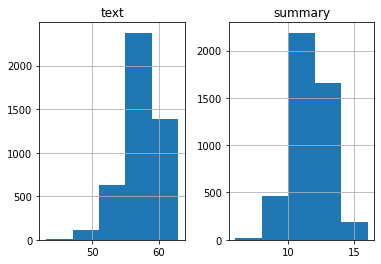

In [ ]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [ ]:
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9997784669915818


In [ ]:
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

1.0


In [ ]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15

In [ ]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre.head(2)

,text,summary
0,the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august the ad...,_START_ daman diu revokes mandatory rakshabandhan in offices order _END_
1,malaika arora slammed an instagram user who trolled her for divorcing rich man and having fun with the alimony her life now is all about wearing short clothes going to gym or salon enjoying vacati...,_START_ malaika slams user who trolled her for divorcing rich man _END_


In [ ]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
post_pre.head(2)

,text,summary
0,the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august the ad...,sostok _START_ daman diu revokes mandatory rakshabandhan in offices order _END_ eostok
1,malaika arora slammed an instagram user who trolled her for divorcing rich man and having fun with the alimony her life now is all about wearing short clothes going to gym or salon enjoying vacati...,sostok _START_ malaika slams user who trolled her for divorcing rich man _END_ eostok


In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)


In [ ]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.01994071678793
Total Coverage of rare words: 7.826268336497612


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 6306


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 84.99636715911844
Total Coverage of rare words: 22.4669359747662


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 1240


In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 6306
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     1261200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=21,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/21
32/32 [==============================] - 260s 8s/step - loss: 4.6657 - val_loss: 3.2205
Epoch 2/21
32/32 [==============================] - 245s 8s/step - loss: 3.2547 - val_loss: 2.9063
Epoch 3/21
32/32 [==============================] - 249s 8s/step - loss: 3.1285 - val_loss: 2.8328
Epoch 4/21
32/32 [==============================] - 246s 8s/step - loss: 2.9694 - val_loss: 2.8099
Epoch 5/21
32/32 [==============================] - 254s 8s/step - loss: 2.9294 - val_loss: 2.7724
Epoch 6/21
32/32 [==============================] - 247s 8s/step - loss: 2.8926 - val_loss: 2.7539
Epoch 7/21
32/32 [==============================] - 254s 8s/step - loss: 2.8559 - val_loss: 2.7432
Epoch 8/21
32/32 [==============================] - 258s 8s/step - loss: 2.8076 - val_loss: 2.7295
Epoch 9/21
32/32 [==============================] - 254s 8s/step - loss: 2.7767 - val_loss: 2.7085
Epoch 10/21
32/32 [==============================] - 253s 8s/step - loss: 2.7908 - val_loss: 2.7006
Epoch 11/

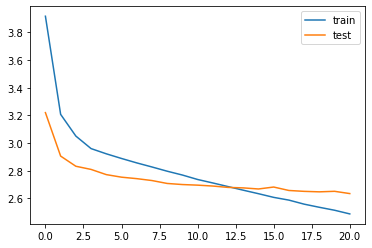

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: the police has banned in groups in leone citing public order and safety the police accused people in groups of insults traffic on vehicles playing music and property from other members of the public it said violators will be with according to law you have been warned 
Original summary: start bans in groups end 
Predicted summary:  start to be in india end


Review: thirty two year old jammu and kashmir police officer ahmed dar who was buried on friday had written facebook post just yourself in your grave down there in that dark hole alone dar along with five other policemen was killed on friday in an in in anantnag district by suspected lashkar e taiba let militants 
Original summary: start just in cop on end 
Predicted summary:  start to be in india end


Review: for changing the names of the central government schemes bjp leader chandra kumar bose compared west bengal cm mamata banerjee to mughal babur who demolished ram temple in ayodhya and built babri masjid think it very 